In [1]:
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [16]:
sns.set_style('dark')
sns.set_palette('mako')

In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'c:/Users/Diego/GitHub/bigquery-chiago-taxi/sql-practice-cred.json'

In [5]:
client = bigquery.Client()

In [22]:
def query_func(query):
    query_job = client.query(query)

    while query_job.state != 'DONE':
        query_job.reload()
        time.sleep(3)

    if query_job.state == 'DONE':
        df = query_job.to_dataframe()
        return df
    else:
        print(query_job.result())

In [23]:
query = """
WITH trips AS(
  SELECT
  EXTRACT(YEAR FROM trip_start_timestamp) year,
  COUNT(*) all_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  GROUP BY 1
)

SELECT
  year,
  all_trips,
  all_trips - LAG(all_trips, 1, 0) OVER(ORDER BY year) AS year_to_year_difference 
FROM trips
GROUP BY 1,2
ORDER BY 1;
"""

yoy_trips = query_func(query)

yoy_trips

,year,all_trips,year_to_year_difference
0,2013,27217300,27217300
1,2014,37395079,10177779
2,2015,32385527,-5009552
3,2016,31756403,-629124
4,2017,24979611,-6776792
5,2018,20731105,-4248506
6,2019,16476440,-4254665
7,2020,3888831,-12587609
8,2021,3947677,58846
9,2022,6382071,2434394


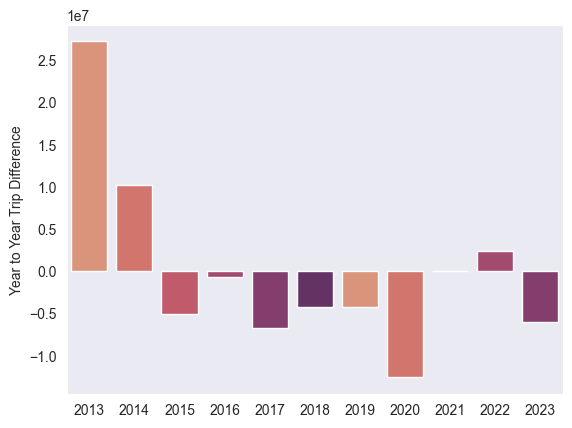

In [45]:
bar = sns.barplot(
    data=yoy_trips,
    y='year_to_year_difference',
    x='year',
    palette=sns.color_palette('flare'),
    
)

bar.set(xlabel='',ylabel='Year to Year Trip Difference')

plt.show()

In [13]:
query = """
SELECT *
FROM ML.EVALUATE(MODEL `chicago_taxi.taxi_fare_model`);
"""

model_stats = query_func(query)

model_stats

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6.835041,6232.760339,0.174885,3.29741,0.047901,0.048938


In [14]:
query = """
SELECT 
  ROUND(predicted_trip_total_cost, 2) predicted_trip_cost
FROM 
  ML.PREDICT(MODEL chicago_taxi.taxi_fare_model, 
  (
  SELECT 
  10 AS tips, 
  '1.00 hrs' AS trip_duration,
  'Mon' AS weekday, 
  17 AS hour)
  );
"""

model_predict = query_func(query)

model_predict

,predicted_trip_cost
0,34.41
